### Generate the estimated gravitational waveform and calculate the signal-to-noise for LVT151012 ###

In [ ]:
# Install the software we need
!pip install lalsuite pycbc

In [2]:
# Get the data open to the public through LOSC
!curl -o H1.gwf https://losc.ligo.org/s/events/LVT151012/H-H1_LOSC_4_V2-1128678884-32.gwf
!curl -o L1.gwf https://losc.ligo.org/s/events/LVT151012/L-L1_LOSC_4_V2-1128678884-32.gwf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1004k  100 1004k    0     0  1756k      0 --:--:-- --:--:-- --:--:-- 1756k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  985k  100  985k    0     0  1774k      0 --:--:-- --:--:-- --:--:-- 1778k


In [3]:
# Make a template from the public parameters from the LOSC and filter 
# the data to get the phase difference.
from pycbc.waveform import get_fd_waveform
z = 0.20
m1 = 23 * (1 + z) 
m2 = 13 * (1 + z)
time = 1128678900.44
hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=m1, mass2=m2, delta_f=1.0/32, f_lower=20)

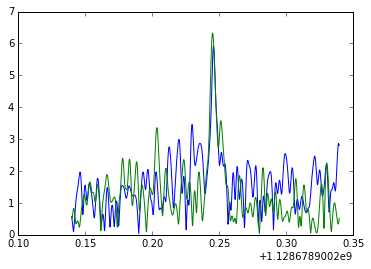

In [4]:
# Calculate the SNR in both the L1 and H1 gravitational-wave detectors
# See that there is a peak in the SNR near the same time.
%matplotlib inline
import pylab
from pycbc.filter import highpass_fir
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, welch
from pycbc.frame import read_frame

for ifo in ['L1', 'H1']:
    # Read in the data into a TimeSeries
    ts = highpass_fir(read_frame('%s.gwf' % ifo, '%s:LOSC-STRAIN' % ifo), 15, 16)

    # Estimate the noise spectrum
    psd = interpolate(welch(ts), 1.0 / ts.duration)
    
    # Calculate the signal-to-noise
    hp.resize(len(ts) / 2 + 1)
    snr = matched_filter(hp, ts, psd=psd, low_frequency_cutoff=30.0)

    # Choose the +-100ms around the event.
    i = int((time - snr.start_time) / snr.delta_t)
    snr = snr[int(i - snr.sample_rate * .1):int(i + snr.sample_rate * .1)]
    
    pylab.plot(snr.sample_times, abs(snr))